In [2]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import geopandas as gpd

from shapely.geometry import Point
from shapely import wkt
import contextily as ctx
from sklearn.neighbors import KernelDensity

In [3]:
survey = pd.read_csv('Qualtrics_May 27, 2025_labels.csv')
survey = survey.iloc[1:].reset_index(drop=True)

**Exploratory Data Analysis: Most demographic Questions Visualized (Not Q5)**

*Question 5 asks about intersection closest to residence - we will map that another way*

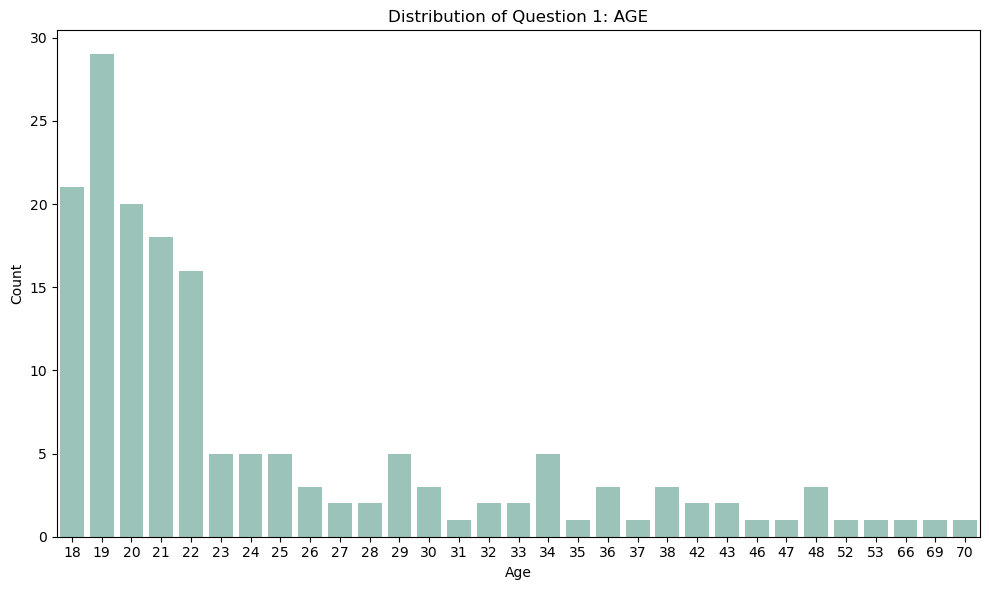

In [4]:
#Question 1: Age

# Convert to numeric, set errors='coerce' to turn non-numeric values into NaN
survey["Question 1"] = pd.to_numeric(survey["Question 1"], errors='coerce')

# Count frequencies and sort by the response value
countsage = survey["Question 1"].value_counts().sort_index()

# Convert to DataFrame for seaborn
counts_df = countsage.reset_index()
counts_df.columns = ["Age", "Count"]
total = counts_df["Count"].sum()
counts_df["Percent"] = counts_df["Count"] / total * 100

# Create an ordered list for the x-axis starting from 18
age_order = sorted(counts_df["Age"].dropna().astype(int).tolist())

plt.figure(figsize=(10, 6))
sns.barplot(data=counts_df, x="Age", y="Count", order=age_order, color="#69b3a2", alpha=0.7)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Question 1: AGE")
plt.tight_layout()
plt.show()

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\1495622872.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=counts_df, x="Age Group", y="Count", palette = "Set3")


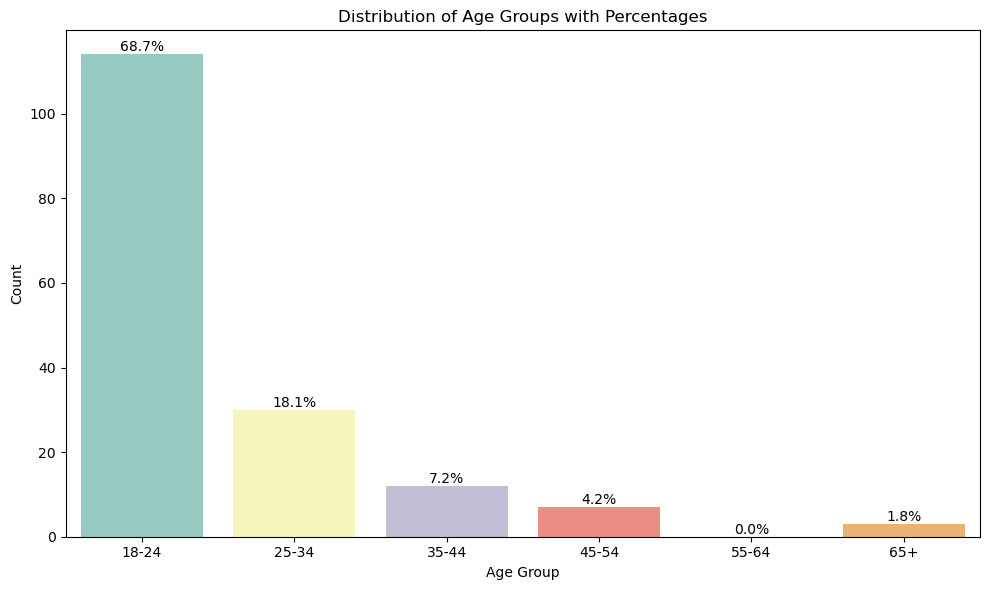

In [5]:
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
survey['Age Group'] = pd.cut(survey['Question 1'], bins=bins, labels=labels, right=False)
counts = survey['Age Group'].value_counts().sort_index()
counts_df = counts.reset_index()
counts_df.columns = ["Age Group", "Count"]
total = counts_df["Count"].sum()
counts_df["Percent"] = counts_df["Count"] / total * 100

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=counts_df, x="Age Group", y="Count", palette = "Set3")
for i, p in enumerate(ax.patches):
    height = p.get_height()
    percent = counts_df.iloc[i]["Percent"]
    ax.annotate(f'{percent:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.title("Distribution of Age Groups with Percentages")
plt.tight_layout()
plt.show()


C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\3409434564.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=survey, x="Question 2", palette = "Set2")


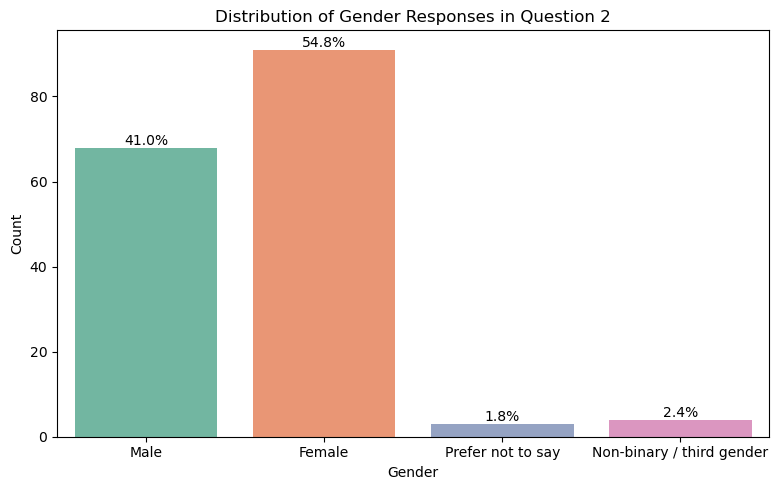

In [6]:
#Question 2: Gender

plt.figure(figsize=(8, 5))
ax = sns.countplot(data=survey, x="Question 2", palette = "Set2")

# Calculate total responses for percentage calculation
total = len(survey["Question 2"].dropna())

# Add percentages on top of each bar
for p in ax.patches:
    height = p.get_height()
    percent = f'{100 * height / total:.1f}%'
    ax.annotate(percent, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Distribution of Gender Responses in Question 2")
plt.tight_layout()
plt.show()

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\1887284935.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=counts_df, x="Response", y="Count", palette="Set2")


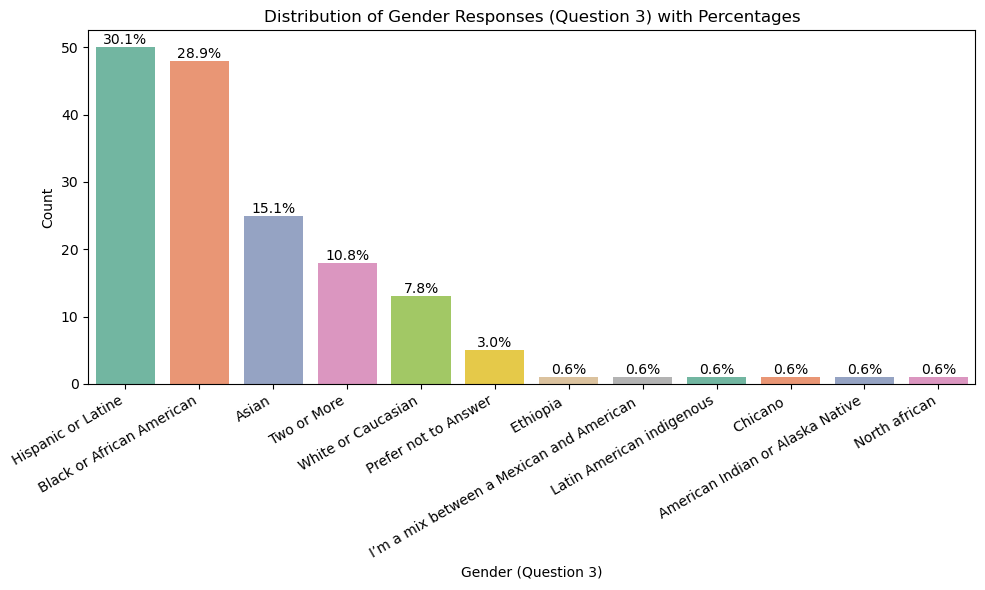

In [7]:
#Question 3: Race/Ethnicity

# Step 1: Replace "Prefer to self describe:" with custom text
mask = survey["Question 3"] == "Prefer to Self Describe:"
survey.loc[mask, "Question 3"] = survey.loc[mask, "Question 3_7_TEXT"]
survey.loc[survey["Question 3"].str.contains(",", na=False), "Question 3"] = "Two or More"


# Step 2: Count frequencies and calculate percentages
counts = survey["Question 3"].value_counts(dropna=False)
percentages = counts / counts.sum() * 100
counts_df = counts.reset_index()
counts_df.columns = ["Response", "Count"]
counts_df["Percent"] = percentages.values

# Step 3: Plot with Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=counts_df, x="Response", y="Count", palette="Set2")

# Step 4: Annotate each bar with its percentage
for i, p in enumerate(ax.patches):
    height = p.get_height()
    percent = counts_df.iloc[i]["Percent"]
    ax.annotate(f'{percent:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel("Gender (Question 3)")
plt.ylabel("Count")
plt.title("Distribution of Gender Responses (Question 3) with Percentages")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

Compared to the total percentages at the District Level:

 - Hispanic/Latine 30.7% (close at 30.1%)
 - Black or African American 19.5% (overrepresented at 28.9%)
 - Asian 19.4% (slightly underrepresented, maybe close at 15.1%)
 - White or Caucasian 18.9% (underreppresented at 7.8%)
 - Two or more 6.7% (slightly overrepresented at 10.8%)

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\1811098284.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=counts_df, x='Response', y='Count', palette='Set2')


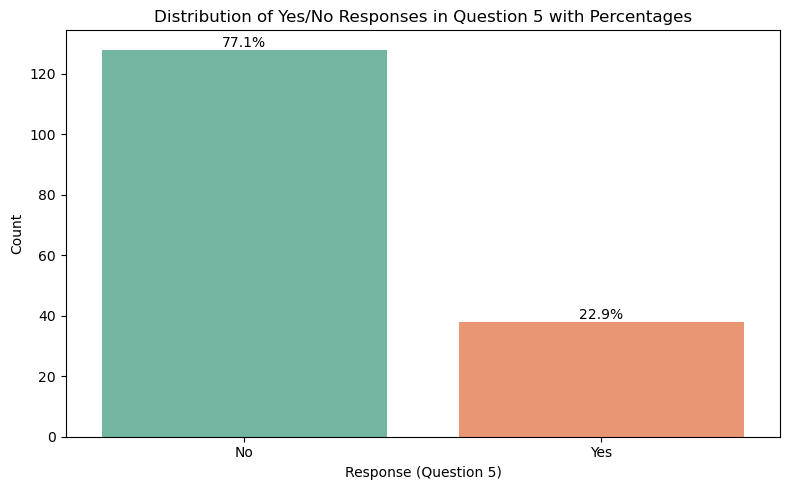

In [8]:
# Question 4 : Caregiver status

# Count frequencies of 'Yes' and 'No' in 'Question 4'
counts = survey['Question 4'].value_counts(dropna=False)
percentages = counts / counts.sum() * 100
counts_df = counts.reset_index()
counts_df.columns = ['Response', 'Count']
counts_df['Percent'] = percentages.values

# Plot with Seaborn
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=counts_df, x='Response', y='Count', palette='Set2')

# Annotate each bar with its percentage
for i, p in enumerate(ax.patches):
    height = p.get_height()
    percent = counts_df.iloc[i]['Percent']
    ax.annotate(f'{percent:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Response (Question 5)')
plt.ylabel('Count')
plt.title('Distribution of Yes/No Responses in Question 5 with Percentages')
plt.tight_layout()
plt.show()

Now we will also skip Question 5 and go to Question 6 to see the distribution of the primary colleges that the survyed students attend.

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\167107193.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=counts_df, x='x_label', y='Count', palette='Set2')


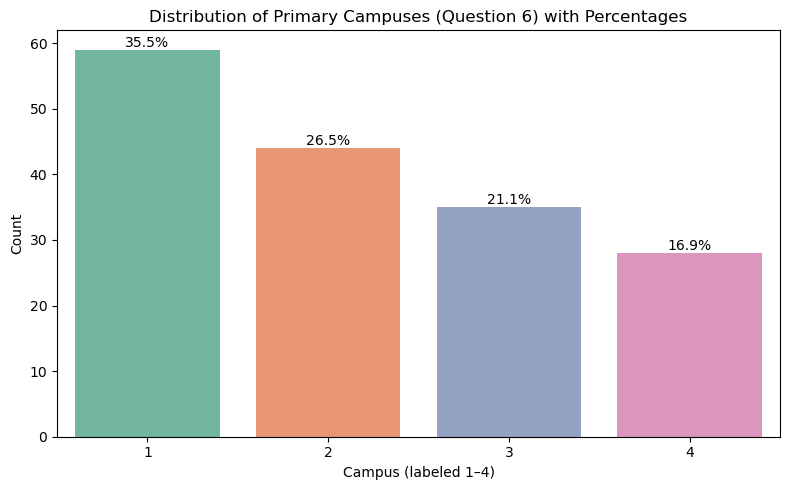

In [9]:
#Question 6 : Primary Campus Attended

import matplotlib.pyplot as plt
import seaborn as sns

# Count frequencies of responses in 'Question 6'
counts = survey['Question 6'].value_counts(dropna=False)
percentages = counts / counts.sum() * 100
counts_df = counts.reset_index()
counts_df.columns = ['Response', 'Count']
counts_df['Percent'] = percentages.values

# Assign numeric x-axis labels (1 to N)
counts_df['x_label'] = range(1, len(counts_df) + 1)

# Plot with Seaborn using numeric x-axis
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=counts_df, x='x_label', y='Count', palette='Set2')

# Annotate each bar with its percentage
for i, p in enumerate(ax.patches):
    height = p.get_height()
    percent = counts_df.iloc[i]['Percent']
    ax.annotate(f'{percent:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

# Set numeric x-ticks
ax.set_xticks(range(len(counts_df)))
ax.set_xticklabels(counts_df['x_label'])

plt.xlabel('Campus (labeled 1–4)')
plt.ylabel('Count')
plt.title('Distribution of Primary Campuses (Question 6) with Percentages')
plt.tight_layout()
plt.show()


Compared to the total percentages at the district level:

- College 1: 22.7% (overrepresented at 35.5%)
- College 2: 20.3% (slightly overrepresented at 26.5%)
- College 3: 22.4% (close at 21.1%)
- College 4: 34.6% (underrepresented at 16.9%)

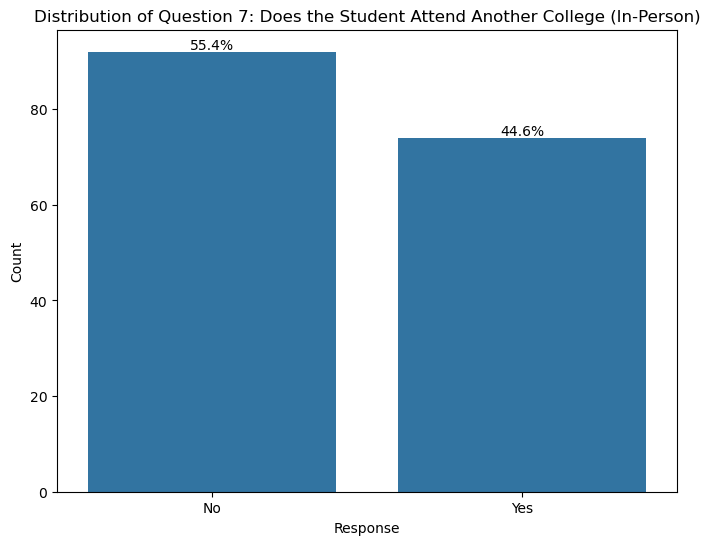

In [10]:
# Question 7 : Attending more than one college in district

# Adding a column for simplification

survey['More Than One College'] = survey.apply(
    lambda row: 'No' if (
        pd.isna(row['Question 7']) or
        (row['Question 6'] == row['Question 7']) or
        (isinstance(row['Question 7'], str) and row['Question 7'].startswith(('I do not', 'I take online')))
    ) else 'Yes',
    axis=1
)

# Now graph 'More Than One College

# Calculate total number of responses
total = len(survey)

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='More Than One College', data=survey)

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 0.5, f'{percentage:.1f}%', ha='center')

plt.title('Distribution of Question 7: Does the Student Attend Another College (In-Person)')
plt.xlabel('Response')
plt.ylabel('Count')
plt.show()


C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\3995799717.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=counts_df, x='Response', y='Count', palette='Set2')
C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\3995799717.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


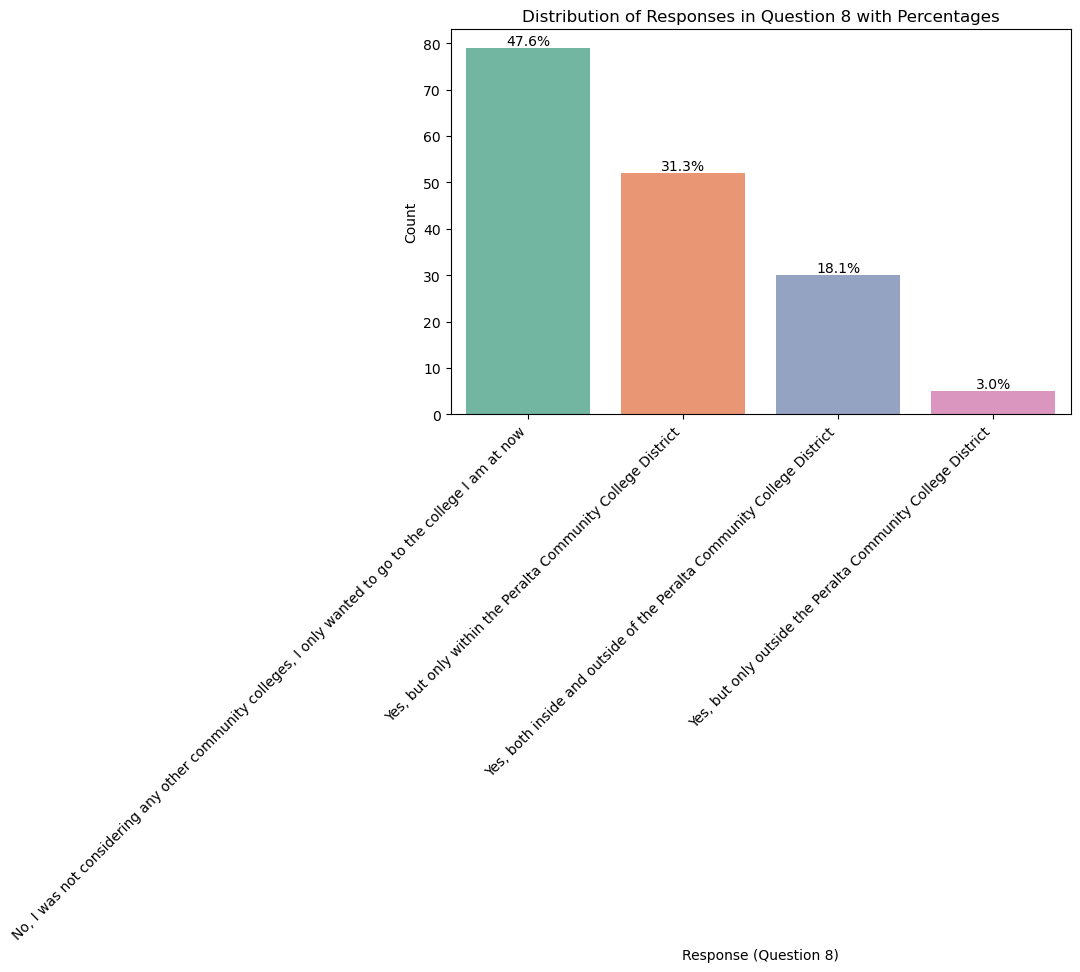

In [11]:
# Question 8: Other College Considerations


# Count frequencies of responses in 'Question 8'
counts = survey['Question 8'].value_counts(dropna=False)
percentages = counts / counts.sum() * 100
counts_df = counts.reset_index()
counts_df.columns = ['Response', 'Count']
counts_df['Percent'] = percentages.values

# Plot with Seaborn
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=counts_df, x='Response', y='Count', palette='Set2')

# Annotate each bar with its percentage
for i, p in enumerate(ax.patches):
    height = p.get_height()
    percent = counts_df.iloc[i]['Percent']
    ax.annotate(f'{percent:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Response (Question 8)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.title('Distribution of Responses in Question 8 with Percentages')
plt.tight_layout()
plt.show()


C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\2143755642.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


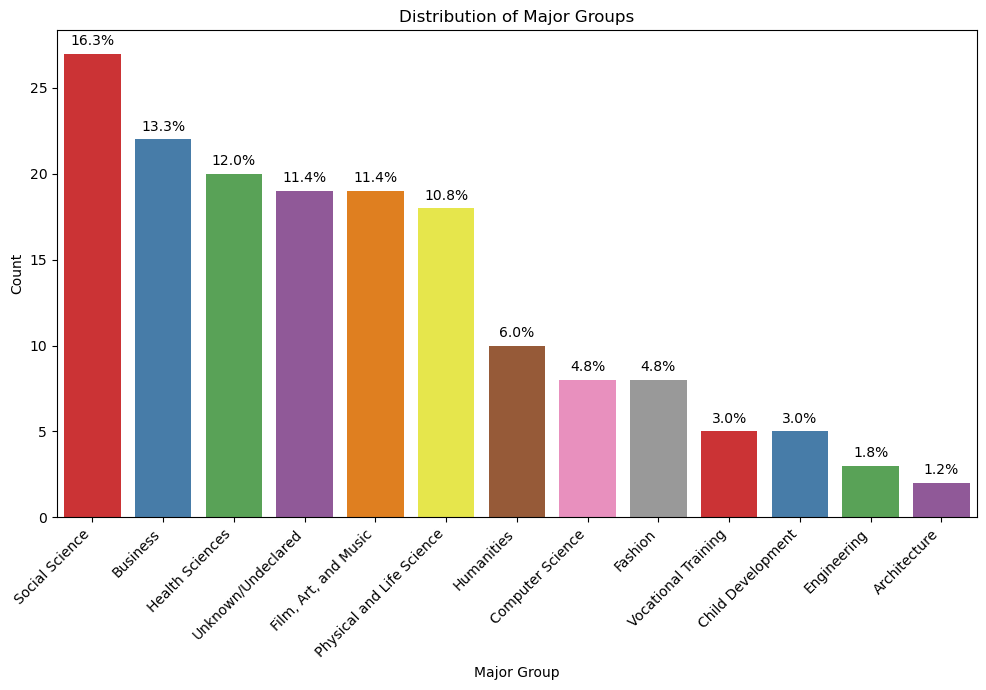

In [12]:
# -- Define your group mapping --
group_mapping = [
    (['Fashion', 'Apparel Design', 'Merchandising'], 'Fashion'),
    (['Business', 'Business Economics', 'Business Administration', 'Real Estate', 'Buisness'], 'Business'),
    (['Film', 'Multimedia', 'Digital Imaging', 'Art', 'Graphic Design', 'Music', 'Music Production', 'Music, Art'], 'Film, Art, and Music'),
    (['Engineering', 'Mechanical Engineering', 'Electrical Engineering'], 'Engineering'),
    (['Unknown', 'Undeclared', 'Blank', 'General Studies', 'Undecided'], 'Unknown/Undeclared'),
    (['Psychology', 'Sociology', 'Social Work', 'Administration of Justice', 'Political Science', 'Criminal justice', 'Legal Studies', 'Urban Studies'], 'Social Science'),
    (['EMT', 'Fire Science', 'Culinary Arts', 'Carpentry'], 'Vocational Training'),
    (['Computer Science', 'Cybersecurity', 'Data Science', 'Computer science'], 'Computer Science'),
    (['Physics', 'Astronomy', 'Biology', 'Biotechnology', 'Natural Sciences', 'Neuroscience', 'Chemistry', 'Marine Biology', 'Psycology, Neuroscience', 'Math', 'Mathmatics'], 'Physical and Life Science'),
    (['Nursing', 'Physician Assistant', 'Radiology', 'Medicine', 'Kinesiology', 'Public Health', 'Nurse', 'Health Science', 'Accounting, Healthcare', 'Nutrition'], 'Health Sciences'),
    (['Japanese', 'Spanish', 'Communications', 'Communication', 'Humanities', 'English', 'History', 'Philosophy', 'Liberal Arts'], 'Humanities'),
    (['Child Development'], 'Child Development'),
    (['Architecture', 'Landscape Architecture'], 'Architecture'),
]

def assign_major_group(major):
    if pd.isna(major) or str(major).strip() == '':
        return 'Unknown/Undeclared'
    major_lower = str(major).lower()
    for keywords, group in group_mapping:
        for keyword in keywords:
            if keyword.lower() in major_lower:
                return group
    return 'Other'

# -- Remove 'Major Group' if it exists, then create it once --
if 'Major Group' in survey.columns:
    survey.drop(columns=['Major Group'], inplace=True)
survey.insert(
    survey.columns.get_loc('Question 9') + 1,
    'Major Group',
    survey['Question 9'].apply(assign_major_group)
)

# -- Plotting --
total = len(survey)
plt.figure(figsize=(10, 7))
ax = sns.countplot(
    x='Major Group',
    data=survey,
    palette='Set1',
    order=survey['Major Group'].value_counts().index
)

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 0.5,
        f'{percentage:.1f}%',
        ha='center'
    )

plt.title('Distribution of Major Groups')
plt.xlabel('Major Group')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
ax.xaxis

                                    Reason  Count
0                         Passion/Interest    126
1                        Job opportunities     76
2     Salary expectations after graduation     26
3  Recommendation by friends/family/mentor     18
4                                    Other     10


C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\1756112995.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Reason', y='Count', data=reason_counts, order=reason_counts['Reason'], palette = 'Set3')


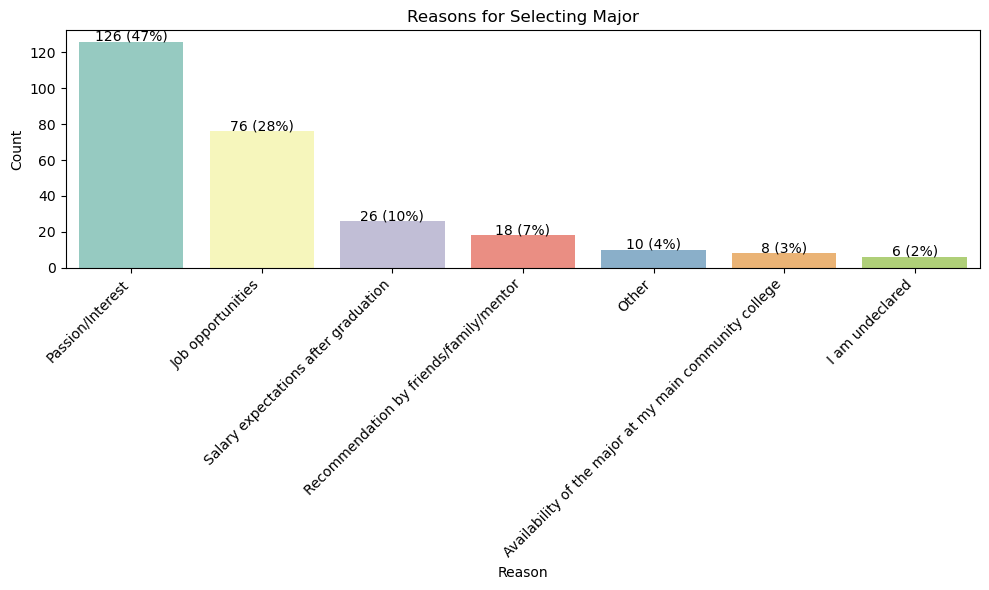

In [13]:
# Question 10: What were the top ONE to TWO reasons for choosing your major?

# Split the entries in 'Question 10' by comma, strip whitespace, and explode into a single column
reasons_series = survey['Question 10'].dropna().str.split(',').explode().str.strip()

# Count the occurrences of each reason
reason_counts = reasons_series.value_counts().reset_index()
reason_counts.columns = ['Reason', 'Count']


# Replace 'Other: (please describe)' with 'Other'
reason_counts['Reason'] = reason_counts['Reason'].replace('Other: (please describe)', 'Other')

# Display the resulting DataFrame
print(reason_counts.head())

# Assuming reason_counts DataFrame is already created as shown above
total_reasons = reason_counts['Count'].sum()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Reason', y='Count', data=reason_counts, order=reason_counts['Reason'], palette = 'Set3')

# Add count and percentage labels on top of each bar, both as integers
for p in ax.patches:
    height = int(round(p.get_height()))
    percentage = int(round((height / total_reasons) * 100))
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 0.5,
        f'{height} ({percentage}%)',
        ha='center'
    )

plt.title('Reasons for Selecting Major')
plt.xlabel('Reason')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\39735820.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Reason', y='Count', data=reason_counts_q11, order=reason_counts_q11['Reason'], palette='pastel')


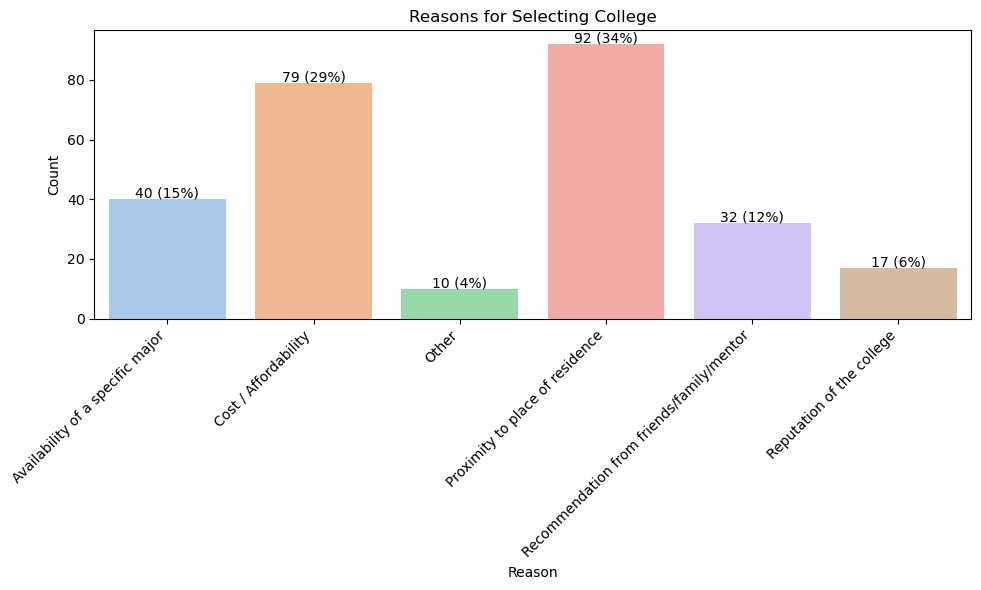

In [14]:
# Question 11: What were the top ONE to TWO factors that influenced your choice of community college?

# Split, explode, and clean up the reasons
reasons_series_q11 = survey['Question 11'].dropna().str.split(',').explode().str.strip()

# Count occurrences
reason_counts_q11 = reasons_series_q11.value_counts().reset_index()
reason_counts_q11.columns = ['Reason', 'Count']

# Combine counts for duplicate labels if needed (e.g., 'Other: (please describe)' to 'Other')
reason_counts_q11['Reason'] = reason_counts_q11['Reason'].replace('Other: (please describe)', 'Other')
reason_counts_q11 = reason_counts_q11.groupby('Reason', as_index=False)['Count'].sum()

# Round counts to nearest whole number
reason_counts_q11['Count'] = reason_counts_q11['Count'].round().astype(int)

total_reasons_q11 = reason_counts_q11['Count'].sum()

# Graph

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Reason', y='Count', data=reason_counts_q11, order=reason_counts_q11['Reason'], palette='pastel')

# Add count and percentage labels on top of each bar, both as integers
for p in ax.patches:
    height = int(round(p.get_height()))
    percentage = int(round((height / total_reasons_q11) * 100))
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 0.5,
        f'{height} ({percentage}%)',
        ha='center',
       
    )

plt.title('Reasons for Selecting College')
plt.xlabel('Reason')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\553384725.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students_with_major['Question 9 Grouped'] = students_with_major['Question 9'].apply(map_to_group)
C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\553384725.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Response', y='Count', data=question_9_counts, palette='pastel')


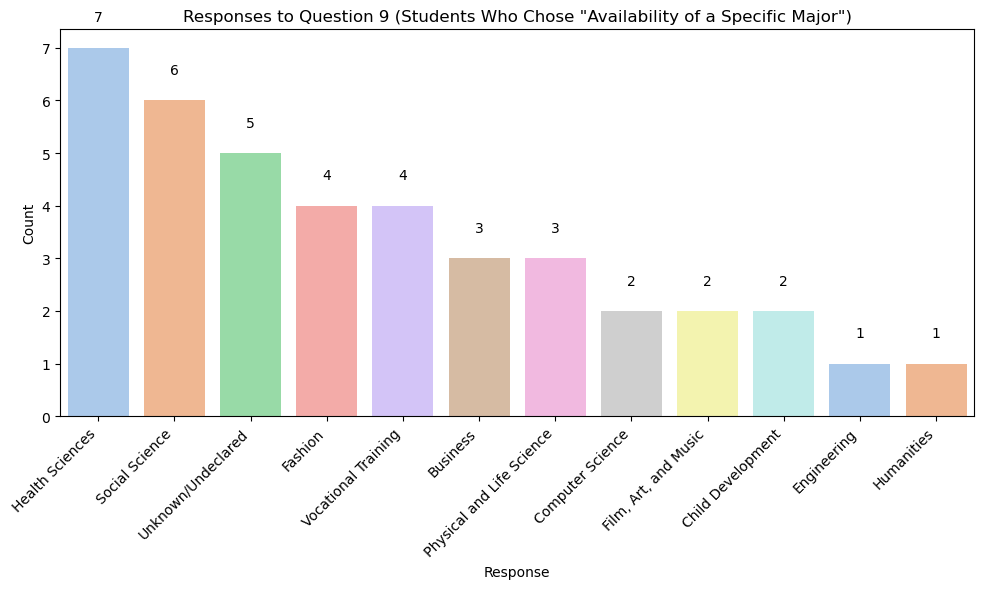

7                   Medicine 
25     Accounting, Healthcare
90                 Radiology 
99            Health Science 
101                 Medicine 
115                   Nursing
151                   Nursing
Name: Question 9, dtype: object


In [15]:
students_with_major = survey[survey['Question 11'].str.contains('Availability of a specific major', na=False)]

# Define your mapping (as shown in your message)
group_mapping = {
    'Fashion': ['Fashion', 'Apparel Design', 'Merchandising'],
    'Business': ['Business', 'Business Economics', 'Business Administration', 'Real Estate', 'Buisness'],
    'Film, Art, and Music': ['Film', 'Multimedia', 'Digital Imaging', 'Art', 'Graphic Design', 'Music', 'Music Production ', 'Music, Art', 'Art History'],
    'Engineering': ['Engineering', 'Mechanical Engineering', 'Electrical Engineering'],
    'Unknown/Undeclared': ['Unknown', 'Undeclared', 'Blank', 'General Studies', 'Undecided'],
    'Social Science': ['Psychology', 'Sociology', 'Social Work', 'Administration of Justice', 'Political Science', 'Criminal justice', 'Legal Studies', 'Urban Studies'],
    'Vocational Training': ['EMT', 'Fire Science', 'Culinary Arts', 'Carpentry'],
    'Computer Science': ['Computer Science', 'Cybersecurity', 'Data Science', 'Computer science'],
    'Physical and Life Science': ['Physics', 'Astronomy', 'Biology', 'Biotechnology', 'Natural Sciences', 'Neuroscience', 'Chemistry', 'Marine Biology', 'Psycology, Neuroscience', 'Math', 'Mathmatics'],
    'Health Sciences': ['Nursing', 'Physician Assistant', 'Radiology', 'Medicine', 'Kinesiology', 'Public Health', 'Nurse', 'Health Science', 'Accounting, Healthcare', 'Nutrition'],
    'Humanities': ['Japanese', 'Spanish', 'Communications', 'Communication', 'Humanities', 'English', 'History', 'Philosophy', 'Liberal Arts'],
    'Child Development': ['Child Development'],
    'Architecture': ['Architecture', 'Landscape Architecture']
}

# Create a reverse mapping for lookup
reverse_mapping = {}
for group, majors in group_mapping.items():
    for major in majors:
        reverse_mapping[major.strip().lower()] = group

# Function to map each response to its group
def map_to_group(response):
    if pd.isna(response):
        return 'Unknown/Undeclared'
    response_clean = response.strip().lower()
    return reverse_mapping.get(response_clean, 'Other')

# Apply the mapping to 'Question 6'
students_with_major['Question 9 Grouped'] = students_with_major['Question 9'].apply(map_to_group)


# Count responses for 'Question 9' among students_with_major
question_9_counts = students_with_major['Question 9 Grouped'].dropna().value_counts().reset_index()
question_9_counts.columns = ['Response', 'Count']

# Plot the results
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Response', y='Count', data=question_9_counts, palette='pastel')

# Add count labels on top of each bar
for p in ax.patches:
    height = int(round(p.get_height()))
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 0.5,
        f'{height}',
        ha='center'
    )

plt.title('Responses to Question 9 (Students Who Chose "Availability of a Specific Major")')
plt.xlabel('Response')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Filter for Health Sciences in 'Question 9 Grouped'
filtered_students_health_sciences = students_with_major[students_with_major['Question 9 Grouped'] == 'Health Sciences']

# View their responses to 'Question 9'
print(filtered_students_health_sciences['Question 9'])


Same thing but separated by college

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\4107820343.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Reason', y='Count', data=reason_counts, order=reason_counts['Reason'], palette='pastel')


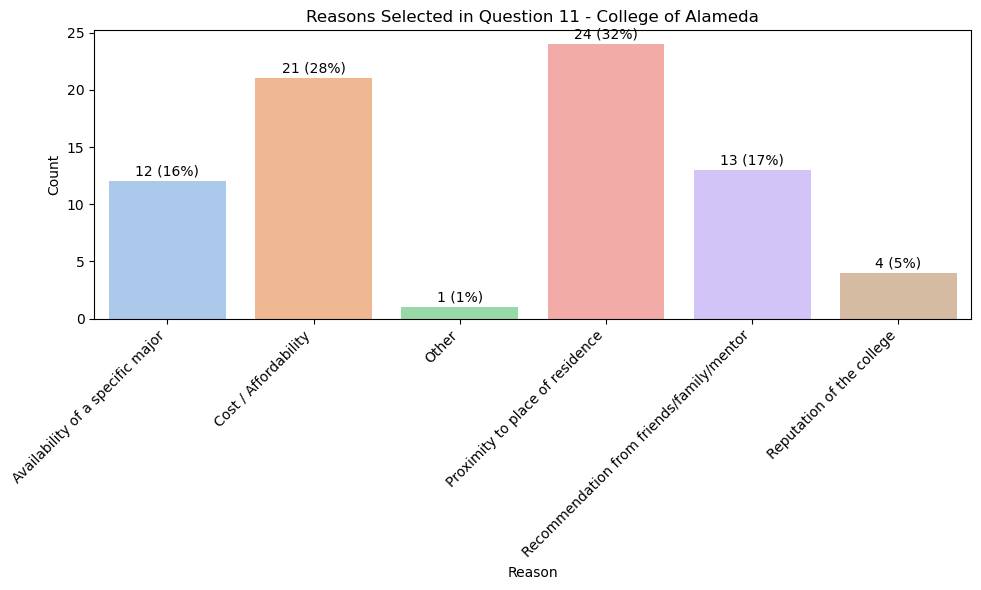

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\4107820343.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Reason', y='Count', data=reason_counts, order=reason_counts['Reason'], palette='pastel')


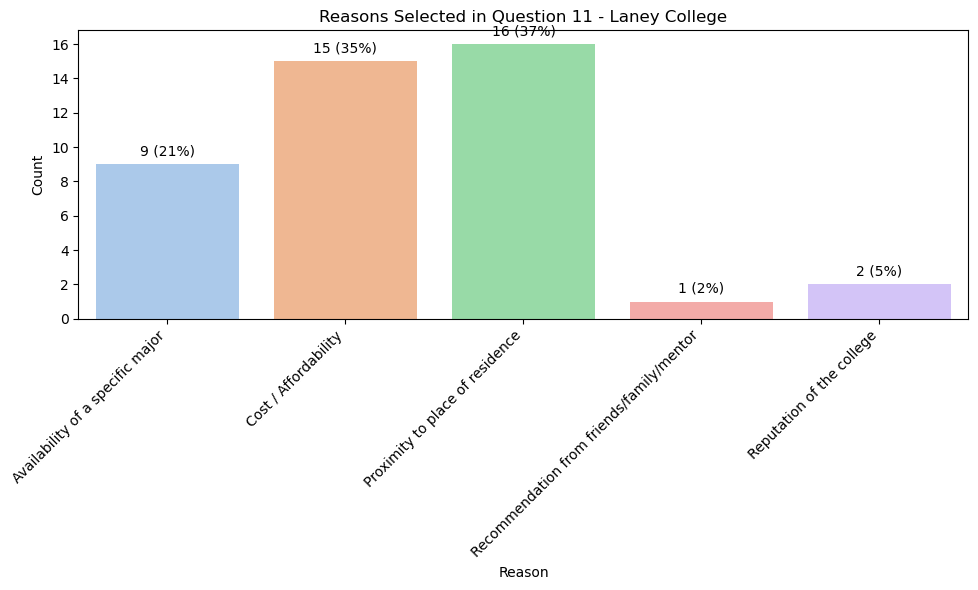

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\4107820343.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Reason', y='Count', data=reason_counts, order=reason_counts['Reason'], palette='pastel')


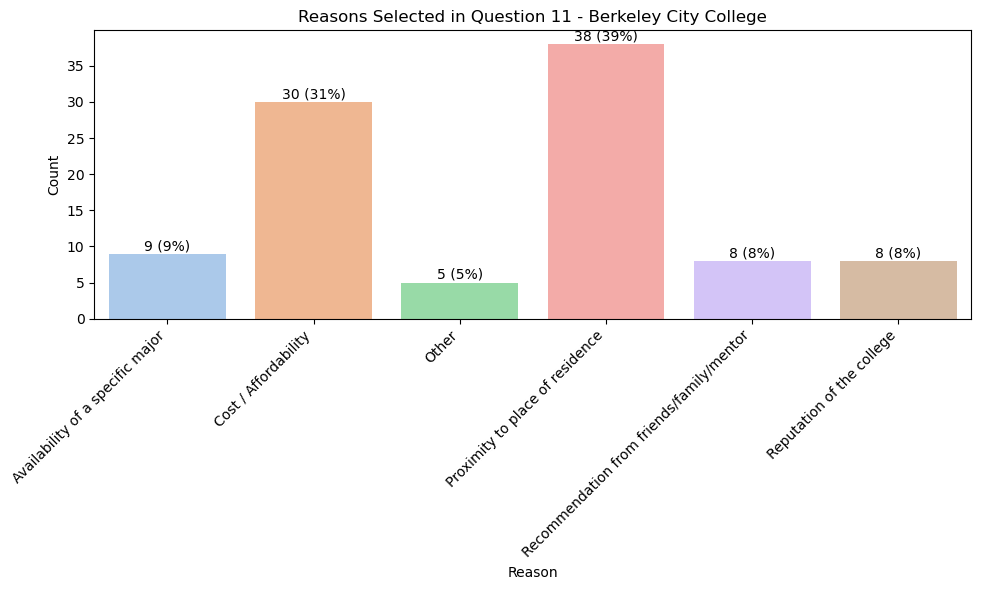

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\4107820343.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Reason', y='Count', data=reason_counts, order=reason_counts['Reason'], palette='pastel')


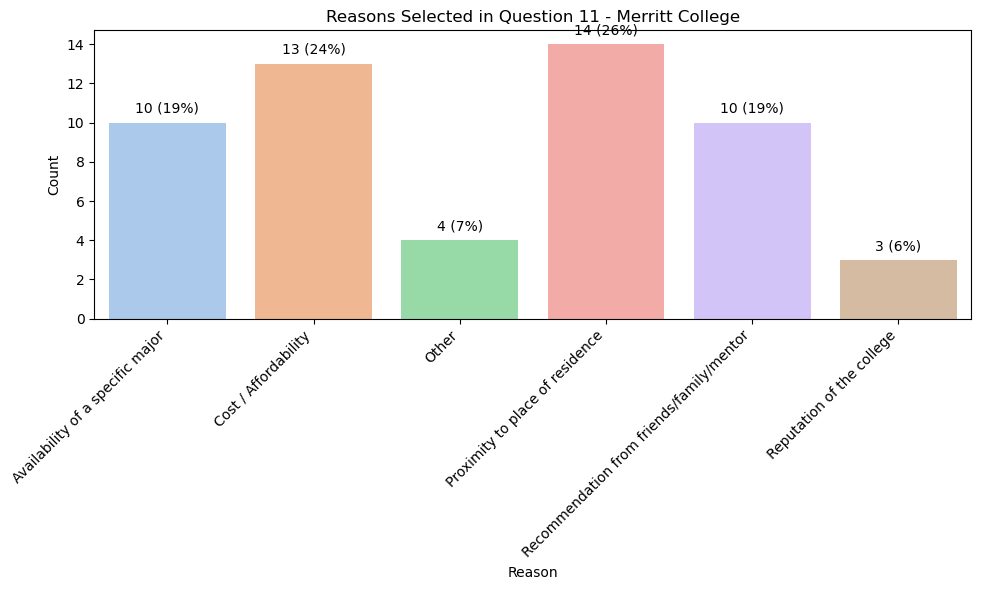

In [16]:

def plot_bar_graphs_by_college(df):
    colleges = df['Question 6'].unique()
    for college in colleges:
        # Filter data for the current college
        college_data = df[df['Question 6'] == college]
        
        # Split, explode, and clean up the responses
        reasons_series = college_data['Question 11'].dropna().str.split(',').explode().str.strip()
        
        # Count occurrences of each response
        reason_counts = reasons_series.value_counts().reset_index()
        reason_counts.columns = ['Reason', 'Count']
        
        # Standardize 'Other: (please describe)' to 'Other'
        reason_counts['Reason'] = reason_counts['Reason'].replace('Other: (please describe)', 'Other')
        reason_counts = reason_counts.groupby('Reason', as_index=False)['Count'].sum()
        
        # Round counts to nearest whole number (for display)
        reason_counts['Count'] = reason_counts['Count'].round().astype(int)
        
        # Plot
        total_reasons = reason_counts['Count'].sum()
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x='Reason', y='Count', data=reason_counts, order=reason_counts['Reason'], palette='pastel')
        
        # Add count and percentage labels on top of each bar
        for p in ax.patches:
            height = int(round(p.get_height()))
            percentage = int(round((height / total_reasons) * 100))
            ax.text(
                p.get_x() + p.get_width() / 2.,
                height + 0.5,
                f'{height} ({percentage}%)',
                ha='center'
            )
        
        plt.title(f'Reasons Selected in Question 11 - {college}')
        plt.xlabel('Reason')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Call the function with your survey dataframe
plot_bar_graphs_by_college(survey)


In [17]:
import pandas as pd
from scipy.stats import chi2_contingency

# Explode the responses so each row is a single barrier choice
exploded = survey.dropna(subset=['Question 13']).copy()
exploded['Barrier'] = exploded['Question 13'].str.split(',')
exploded = exploded.explode('Barrier')
exploded['Barrier'] = exploded['Barrier'].str.strip()
exploded['Barrier'] = exploded['Barrier'].replace('Other: (please describe)', 'Other')

# Create a contingency table: rows = colleges, columns = barrier choices
contingency = pd.crosstab(exploded['Question 6'], exploded['Barrier'])

# Run the Chi-square test of independence
chi2, p, dof, expected = chi2_contingency(contingency)

print(f'Chi-square statistic: {chi2:.2f}')
print(f'p-value: {p:.4f}')
if p < 0.05:
    print('There is a significant difference in barrier choices between colleges.')
else:
    print('No significant difference in barrier choices between colleges.')


Chi-square statistic: 6.12
p-value: 0.9777
No significant difference in barrier choices between colleges.


C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\3604699843.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


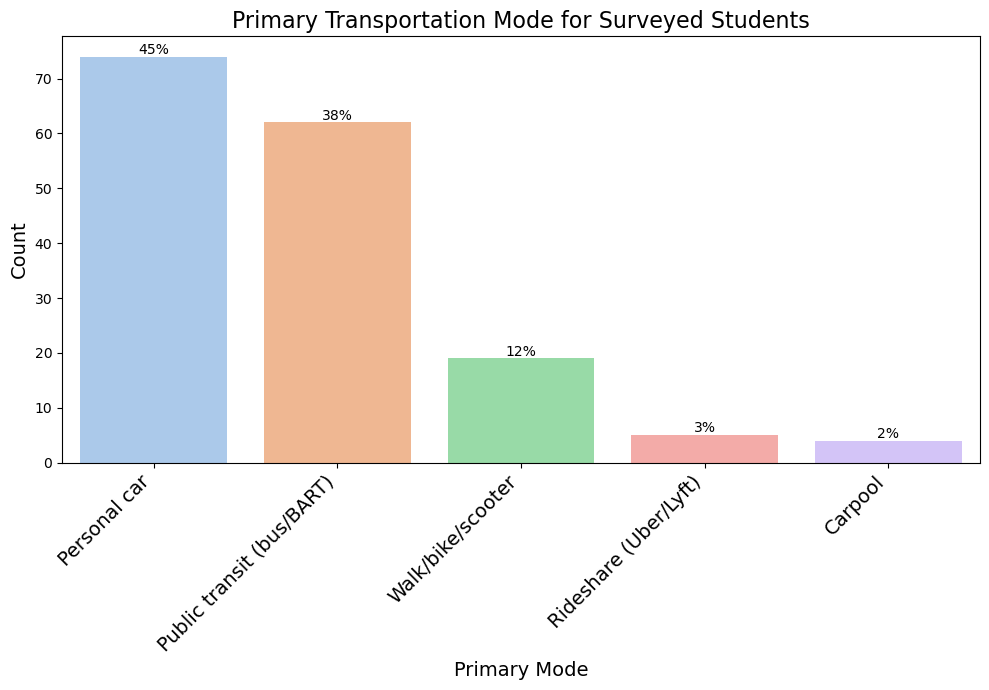

In [18]:
# Question 12 : What is your primary transportation method to get to your community college?

# Calculate value counts and percentages for Question 12
value_counts_q12 = survey['Question 12'].value_counts()
percentage_distribution_q12 = (value_counts_q12 / value_counts_q12.sum()) * 100

# Create a DataFrame with both counts and percentages
q12_stats = pd.DataFrame({
    'Response': value_counts_q12.index,
    'Count': value_counts_q12.values,
    'Percentage': percentage_distribution_q12.values
})

plt.figure(figsize=(10, 7))
ax = sns.barplot(
    x='Response',
    y='Count',
    data=q12_stats,
    order=q12_stats['Response'],
    palette='pastel'
)

# Add percentage labels on top of each bar, rounded to whole numbers
for p, percentage in zip(ax.patches, q12_stats['Percentage']):
    height = int(round(p.get_height()))
    percent_label = int(round(percentage))
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 0.5,
        f'{percent_label}%',
        ha='center'
    )

plt.title('Primary Transportation Mode for Surveyed Students', fontsize = 16)
plt.xlabel('Primary Mode', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(rotation=45, ha='right', fontsize = 14)
plt.tight_layout()
plt.show()


C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\3502655233.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Reason', y='Count', data=reason_counts_q13, order=reason_counts_q13['Reason'], palette='pastel')


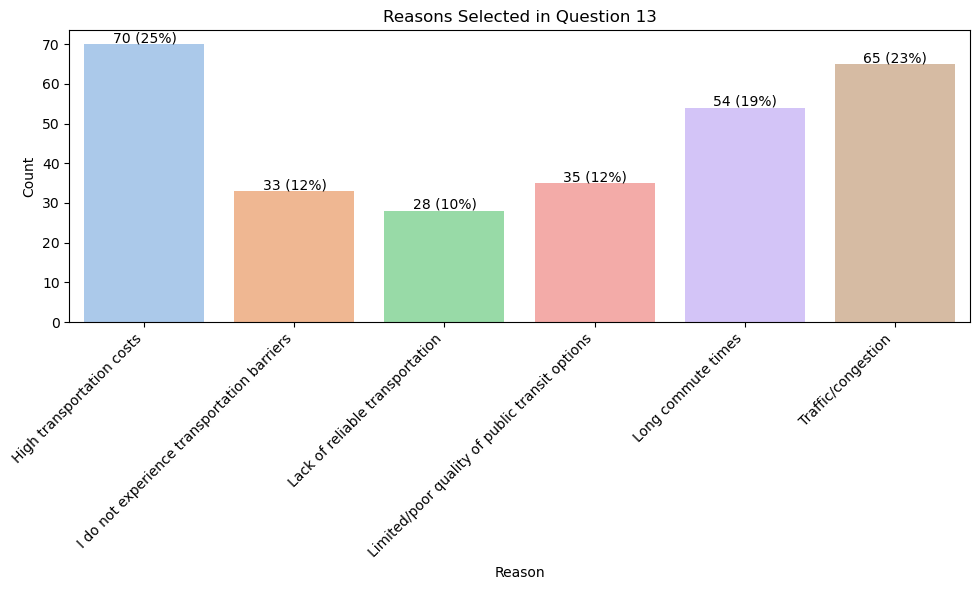

166


In [19]:
# Question 13 : Do you experience any of these transportation barriers? (Check all that apply)

# Split, explode, and clean up the responses
reasons_series_q13 = survey['Question 13'].dropna().str.split(',').explode().str.strip()

# Count occurrences of each response
reason_counts_q13 = reasons_series_q13.value_counts().reset_index()
reason_counts_q13.columns = ['Reason', 'Count']

# (Optional) Standardize 'Other: (please describe)' to 'Other'
reason_counts_q13['Reason'] = reason_counts_q13['Reason'].replace('Other: (please describe)', 'Other')
reason_counts_q13 = reason_counts_q13.groupby('Reason', as_index=False)['Count'].sum()

# Round counts to nearest whole number (for display)
reason_counts_q13['Count'] = reason_counts_q13['Count'].round().astype(int)

# Graph

total_reasons_q13 = reason_counts_q13['Count'].sum()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Reason', y='Count', data=reason_counts_q13, order=reason_counts_q13['Reason'], palette='pastel')

# Add count and percentage labels on top of each bar, both as integers
for p in ax.patches:
    height = int(round(p.get_height()))
    percentage = int(round((height / total_reasons_q13) * 100))
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 0.5,
        f'{height} ({percentage}%)',
        ha='center'
    )

plt.title('Reasons Selected in Question 13')
plt.xlabel('Reason')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(len(survey))

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\4177358256.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


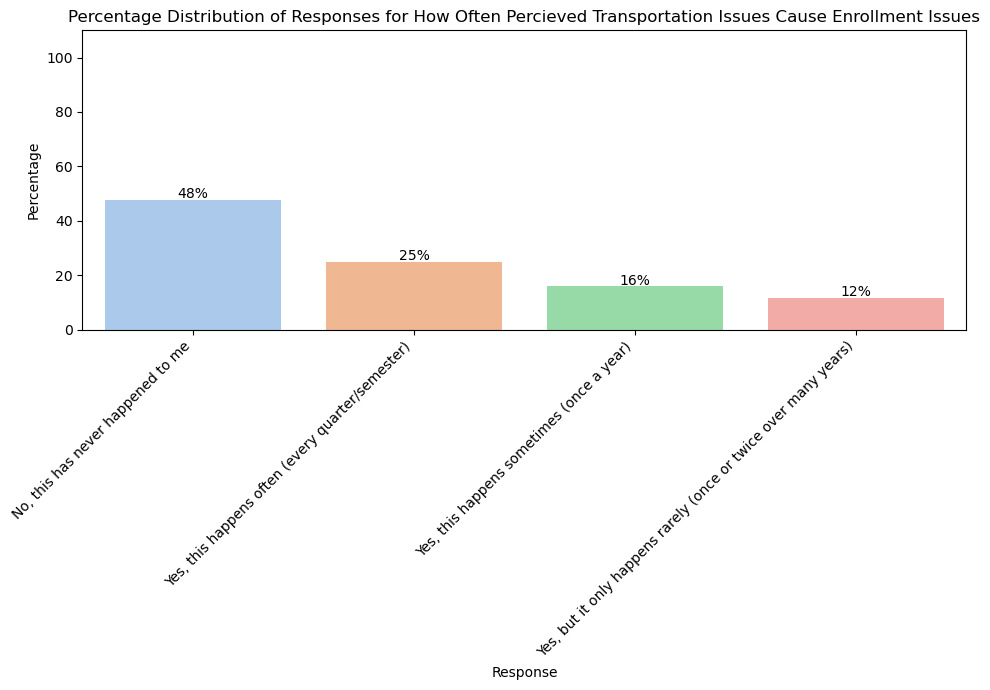

166

In [20]:
# Question 14 : Have you ever not enrolled or postponed enrollment in a course 
# because you believed a transportation issue would impact your success in that course?


# Calculate the percentage distribution for each unique value in 'Question 14'
percentage_distribution_q14 = survey['Question 14'].value_counts(normalize=True) * 100
percentage_distribution_q14 = percentage_distribution_q14.reset_index()
percentage_distribution_q14.columns = ['Response', 'Percentage']

plt.figure(figsize=(10, 7))
ax = sns.barplot(
    x='Response',
    y='Percentage',
    data=percentage_distribution_q14,
    order=percentage_distribution_q14['Response'],
    palette='pastel'
)

# Add percentage labels on top of each bar, rounded to whole numbers
for p in ax.patches:
    height = int(round(p.get_height()))
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 0.5,
        f'{height}%',
        ha='center'
    )

plt.title('Percentage Distribution of Responses for How Often Percieved Transportation Issues Cause Enrollment Issues')
plt.xlabel('Response')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 110)  # Adjust y-axis to make space for labels
plt.tight_layout()
plt.show()
len(survey)

In [21]:
often = survey[survey['Question 14'] == 'Yes, this happens often (every quarter/semester)']

# Show all columns in the output
pd.set_option('display.max_columns', None)




C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\2081070079.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=response_counts.values, y=response_counts.index, palette="Blues_d")


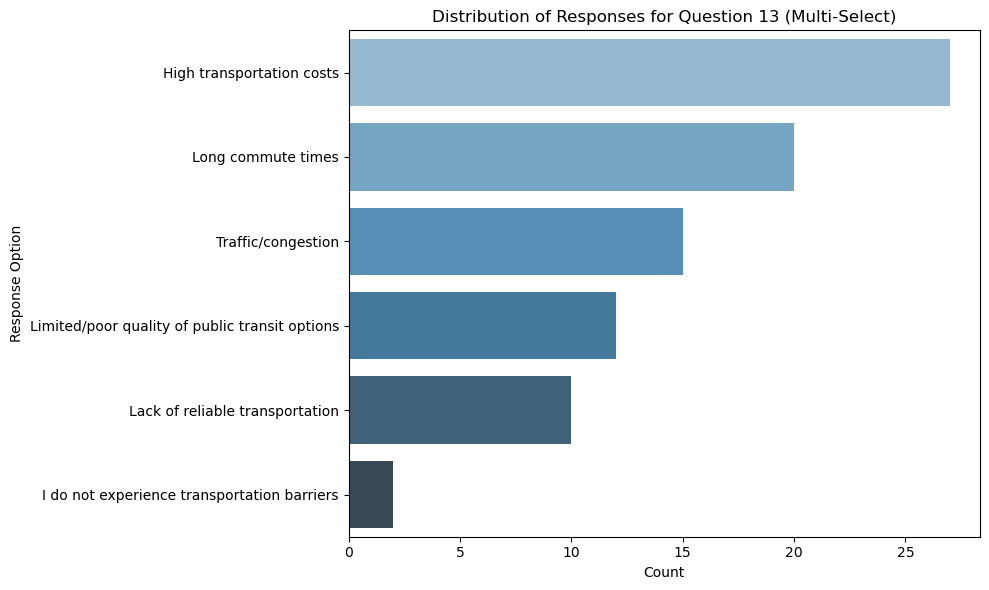

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\2081070079.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=q12_counts.index, y=q12_counts.values, palette=custom_pastel_palette)
C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\2081070079.py:46: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.barplot(x=q12_counts.index, y=q12_counts.values, palette=custom_pastel_palette)


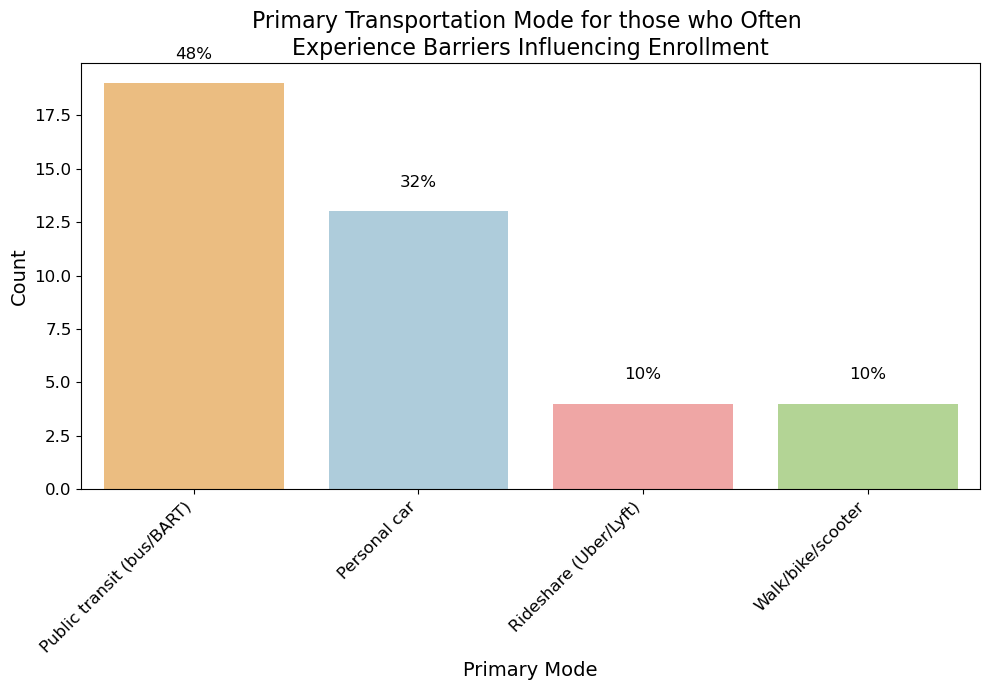

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\2081070079.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=q11_counts.values, y=q11_counts.index, palette="Greens_d")


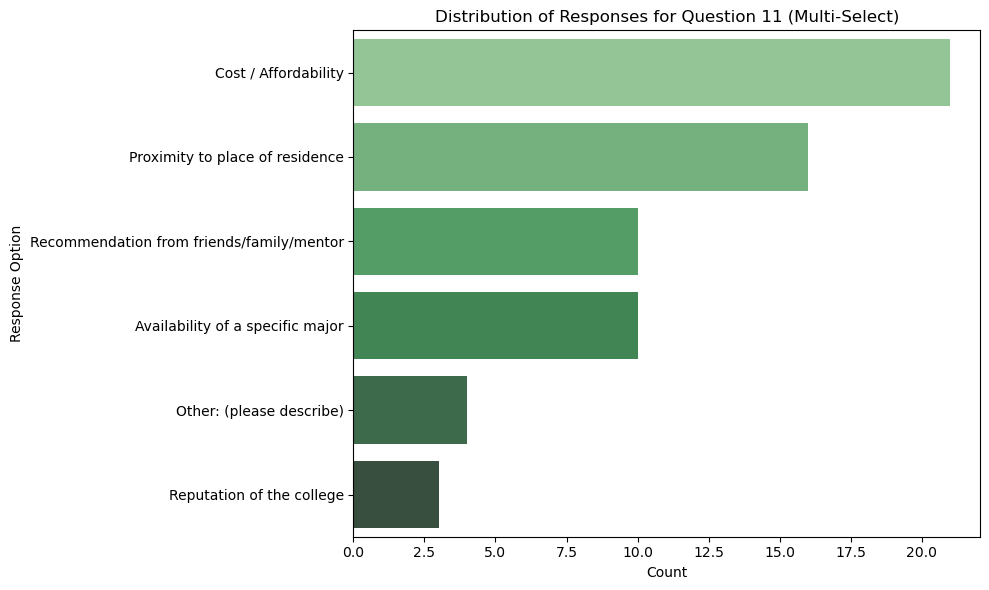

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\2081070079.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=q9_counts.values, y=q9_counts.index, palette="Oranges_d")


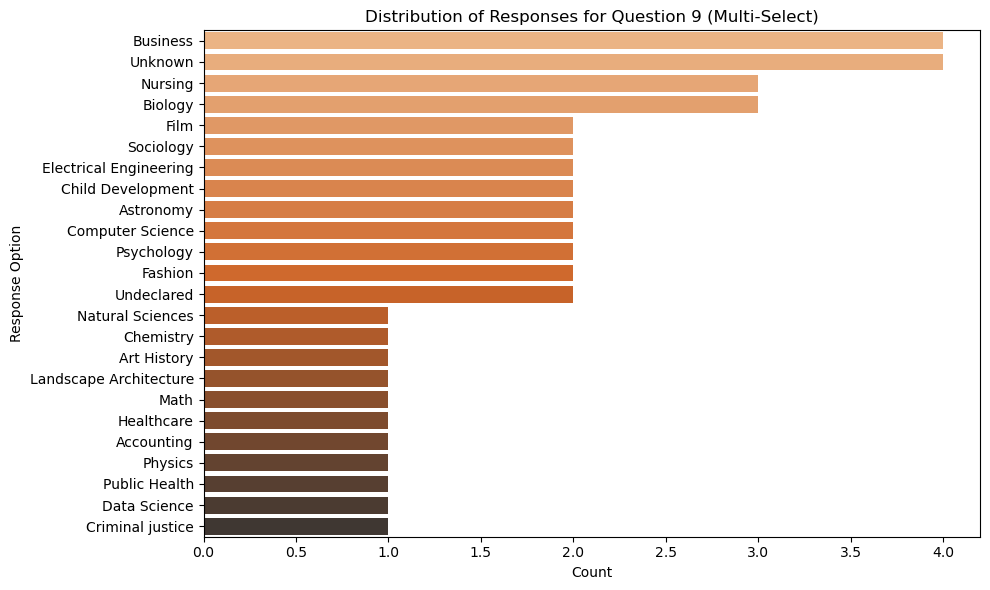

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\2081070079.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=q6_counts.values, y=q6_counts.index, palette="Purples_d")


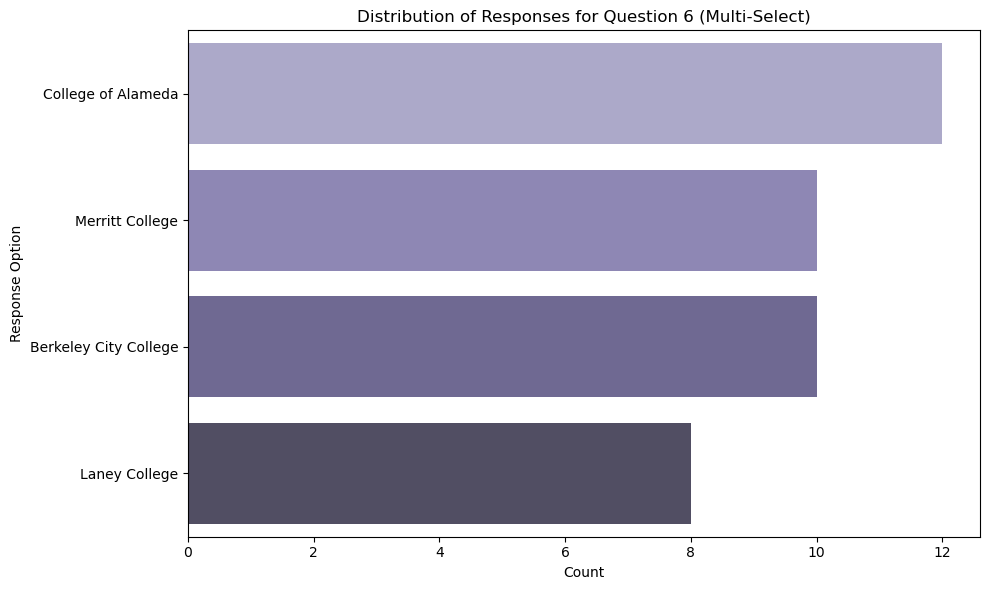

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\2081070079.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=q2_counts.values, y=q2_counts.index, palette="YlGnBu")


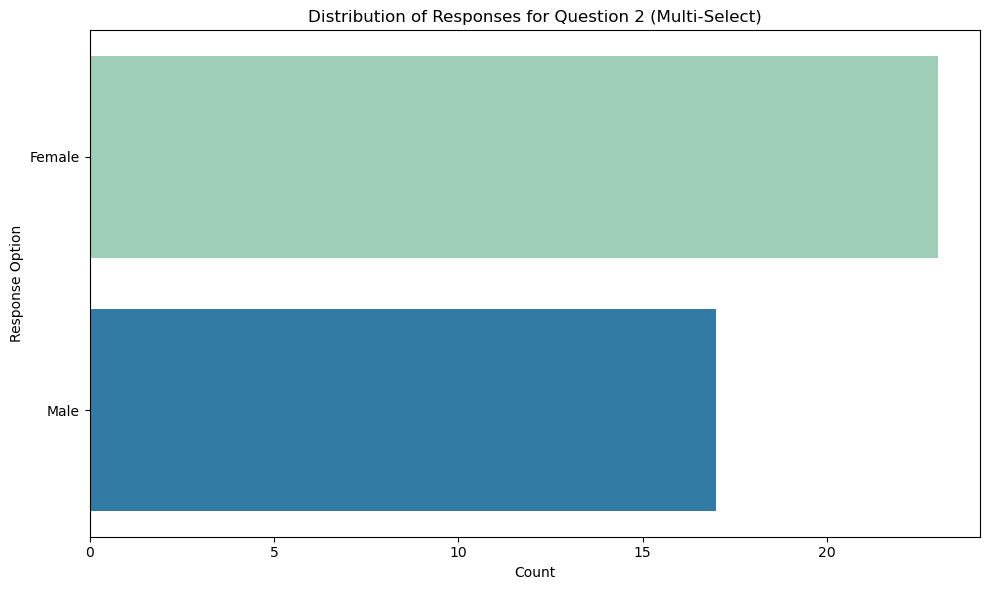

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\2081070079.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=q3_counts.values, y=q3_counts.index, palette="Reds_d")


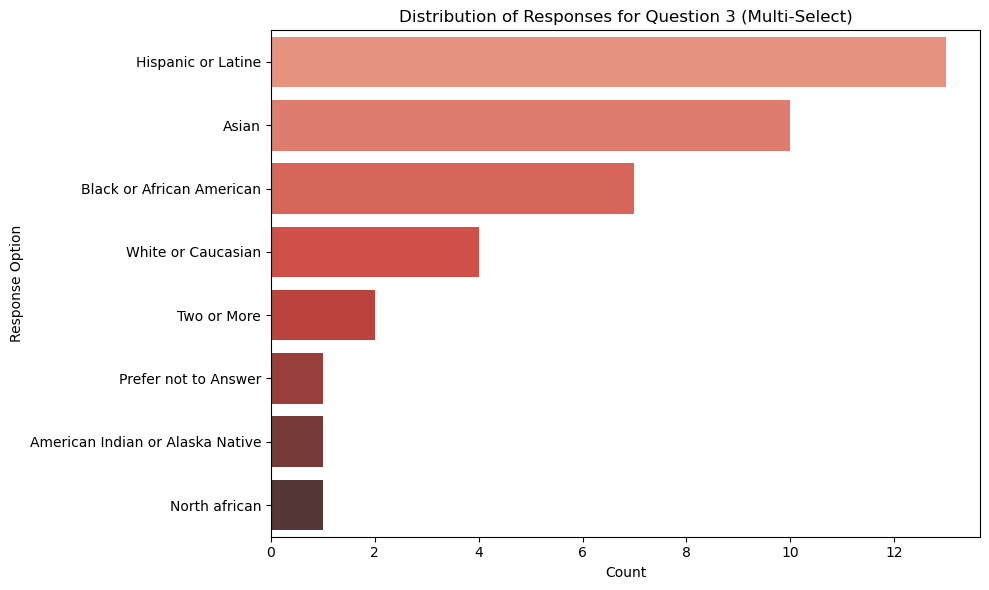

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\2081070079.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=q4_counts.values, y=q4_counts.index, palette="BuPu")


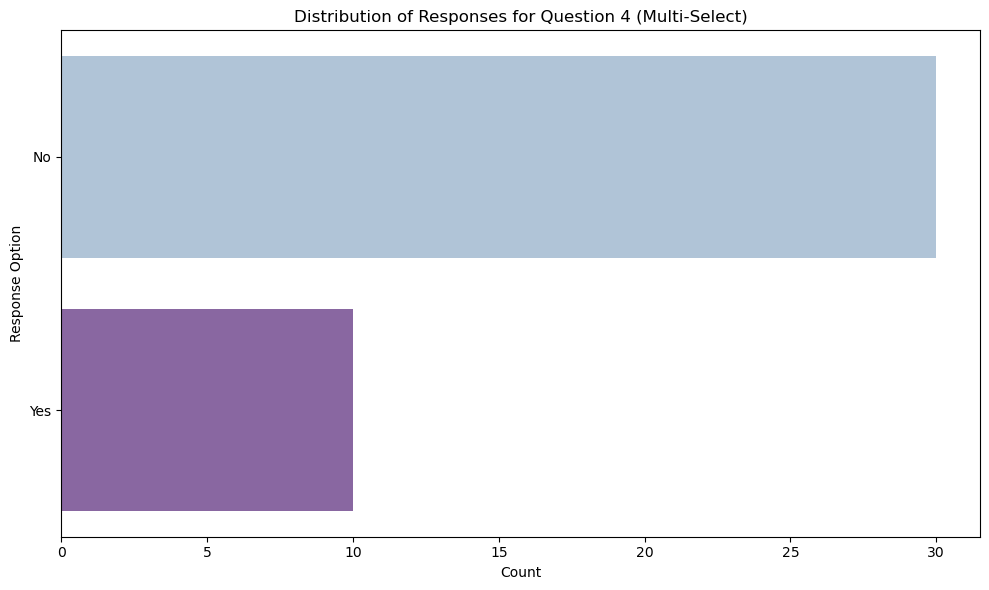

In [22]:
#Question 13

# Drop missing values (if any) in the column
q13_series = often["Question 13"].dropna()

# Split responses by comma, strip whitespace, and flatten into a single list
all_responses = q13_series.str.split(',').explode().str.strip()

# Count occurrences of each response
response_counts = all_responses.value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=response_counts.values, y=response_counts.index, palette="Blues_d")

# Customize
plt.title("Distribution of Responses for Question 13 (Multi-Select)")
plt.xlabel("Count")
plt.ylabel("Response Option")

plt.tight_layout()
plt.show()

#Question 12

custom_pastel_palette = [
    "#fdbf6f",  # Public transit (orange pastel)
    "#a6cee3",  # Personal car (blue pastel)
    "#fb9a99",  # Rideshare (red pastel)
    "#b2df8a",  # Walk/bike/scooter (green pastel)
    "#b2df8a"   # Carpool (green pastel; same as walk/bike)
]


# Drop missing values from Question 12
q12_series = often["Question 12"].dropna()

# Split, strip whitespace, and explode into individual responses
q12_responses = q12_series.str.split(',').explode().str.strip()

# Count each unique response
q12_counts = q12_responses.value_counts()
q12_percentages = (q12_counts / q12_counts.sum()) * 100

plt.figure(figsize=(10, 7))
ax = sns.barplot(x=q12_counts.index, y=q12_counts.values, palette=custom_pastel_palette)

# Add percentage labels above the bars (black)
for i, (count, pct) in enumerate(zip(q12_counts.values, q12_percentages)):
    bar = ax.patches[i]
    ax.text(
        bar.get_x() + bar.get_width()/2,
        count + 1,
        f"{pct:.0f}%",
        ha="center",
        va="bottom",
        fontsize=12,
        color="black",
        
    )

plt.title("Primary Transportation Mode for those who Often \nExperience Barriers Influencing Enrollment", fontsize=16)
plt.xlabel("Primary Mode", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


#Question 11

# Drop missing values from Question 11
q11_series = often["Question 11"].dropna()

# Split, strip whitespace, and explode into individual responses
q11_responses = q11_series.str.split(',').explode().str.strip()

# Count each unique response
q11_counts = q11_responses.value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=q11_counts.values, y=q11_counts.index, palette="Greens_d")

# Customize
plt.title("Distribution of Responses for Question 11 (Multi-Select)")
plt.xlabel("Count")
plt.ylabel("Response Option")

plt.tight_layout()
plt.show()


#Question 9
# Drop missing values from Question 9
q9_series = often["Question 9"].dropna()

# Split, strip whitespace, and explode into individual responses
q9_responses = q9_series.str.split(',').explode().str.strip()

# Count each unique response
q9_counts = q9_responses.value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=q9_counts.values, y=q9_counts.index, palette="Oranges_d")

# Customize
plt.title("Distribution of Responses for Question 9 (Multi-Select)")
plt.xlabel("Count")
plt.ylabel("Response Option")

plt.tight_layout()
plt.show()


#Question 6
# Drop missing values from Question 6
q6_series = often["Question 6"].dropna()

# Split, strip whitespace, and explode into individual responses
q6_responses = q6_series.str.split(',').explode().str.strip()

# Count each unique response
q6_counts = q6_responses.value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=q6_counts.values, y=q6_counts.index, palette="Purples_d")

# Customize
plt.title("Distribution of Responses for Question 6 (Multi-Select)")
plt.xlabel("Count")
plt.ylabel("Response Option")

plt.tight_layout()
plt.show()

#Question 2

# Drop missing values from Question 2
q2_series = often["Question 2"].dropna()

# Split, strip whitespace, and explode into individual responses
q2_responses = q2_series.str.split(',').explode().str.strip()

# Count each unique response
q2_counts = q2_responses.value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=q2_counts.values, y=q2_counts.index, palette="YlGnBu")

# Customize
plt.title("Distribution of Responses for Question 2 (Multi-Select)")
plt.xlabel("Count")
plt.ylabel("Response Option")

plt.tight_layout()
plt.show()


#Question 3
# Drop missing values from Question 3
q3_series = often["Question 3"].dropna()

# Split, strip whitespace, and explode into individual responses
q3_responses = q3_series.str.split(',').explode().str.strip()

# Count each unique response
q3_counts = q3_responses.value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=q3_counts.values, y=q3_counts.index, palette="Reds_d")

# Customize
plt.title("Distribution of Responses for Question 3 (Multi-Select)")
plt.xlabel("Count")
plt.ylabel("Response Option")

plt.tight_layout()
plt.show()



#Question 4

# Drop missing values from Question 4
q4_series = often["Question 4"].dropna()

# Split, strip whitespace, and explode into individual responses
q4_responses = q4_series.str.split(',').explode().str.strip()

# Count each unique response
q4_counts = q4_responses.value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=q4_counts.values, y=q4_counts.index, palette="BuPu")

# Customize
plt.title("Distribution of Responses for Question 4 (Multi-Select)")
plt.xlabel("Count")
plt.ylabel("Response Option")

plt.tight_layout()
plt.show()


In [23]:
survey_exclusive = survey[survey['Question 14'] != 'Yes, this happens often (every quarter/semester)'].copy()


In [24]:
import pandas as pd
from scipy.stats import chi2_contingency

def count_responses(df, question):
    return (
        df[question].dropna()
        .str.split(',')
        .explode()
        .str.strip()
        .value_counts()
    )

# Count responses for Question 13 in both groups
often_counts_q13 = count_responses(often, "Question 3")
survey_exclusive_counts_q13 = count_responses(survey_exclusive, "Question 3")

# Get all unique response options
all_q13_responses = set(often_counts_q13.index).union(set(survey_exclusive_counts_q13.index))

# Create contingency table
contingency_q13 = pd.DataFrame(index=sorted(all_q13_responses), columns=["Often", "Survey Exclusive"]).fillna(0)
contingency_q13["Often"] = contingency_q13.index.map(often_counts_q13).fillna(0)
contingency_q13["Survey Exclusive"] = contingency_q13.index.map(survey_exclusive_counts_q13).fillna(0)

# Run Chi-Square test
chi2_stat_q13, p_value_q13, dof_q13, expected_q13 = chi2_contingency(contingency_q13.T)

# Print results
print("Chi-Square Test of Independence on Question 6 Responses")
print(f"Chi2 Statistic: {chi2_stat_q13:.3f}")
print(f"Degrees of Freedom: {dof_q13}")
print(f"P-Value: {p_value_q13:.4f}")

# Optional: Show expected frequencies
expected_df_q13 = pd.DataFrame(expected_q13, index=["Often", "Survey Exclusive"], columns=contingency_q13.index)
print("\nExpected Frequencies:")
print(expected_df_q13)


Chi-Square Test of Independence on Question 6 Responses
Chi2 Statistic: 15.710
Degrees of Freedom: 11
P-Value: 0.1522

Expected Frequencies:
                  American Indian or Alaska Native      Asian  \
Often                                     0.236364   5.909091   
Survey Exclusive                          0.763636  19.090909   

                  Black or African American   Chicano  Ethiopia  \
Often                             11.345455  0.236364  0.236364   
Survey Exclusive                  36.654545  0.763636  0.763636   

                  Hispanic or Latine  \
Often                      11.818182   
Survey Exclusive           38.181818   

                  I’m a mix between a Mexican and American  \
Often                                             0.236364   
Survey Exclusive                                  0.763636   

                  Latin American indigenous  North african  \
Often                              0.236364       0.236364   
Survey Exclusive             

C:\Users\jcoll\AppData\Local\Temp\ipykernel_2172\764650079.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  contingency_q13 = pd.DataFrame(index=sorted(all_q13_responses), columns=["Often", "Survey Exclusive"]).fillna(0)


In [25]:
len(survey)

166